In [1]:
#import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
import torch

#random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Load data

In [2]:
df_train = pd.read_csv('Kannada-MNIST/train.csv')
df_val = pd.read_csv('Kannada-MNIST/Dig-MNIST.csv')
df_test = pd.read_csv('Kannada-MNIST/test.csv')

df_train.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Make train and validation datasets, check dimensions

In [3]:
X_train = df_train.drop(['label'], axis=1)
y_train = df_train['label']

X_val = df_val.drop(['label'], axis=1)
y_val = df_val['label']

#X_test = df_test.copy()

# Закомментируй следующую строку, если хочешь смотреть на валидацию по отдельному датасету!
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=666)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((60000, 784), (60000,), (10240, 784), (10240,))

### Check distribution

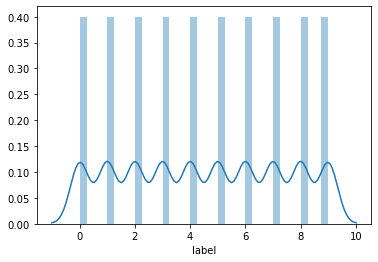

In [4]:
sns.distplot(y_train);

### Reshape and convert data

In [5]:
X_train = X_train.values.reshape([-1, 28, 28])
y_train = y_train.values

X_val = X_val.values.reshape([-1, 28, 28])
y_val = y_val.values

X_train.shape, X_val.shape

((60000, 28, 28), (10240, 28, 28))

### Plot random object from database

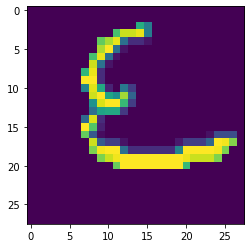

6


In [6]:
plt.imshow(X_train[666, :, :])
plt.show()

print(y_train[666])

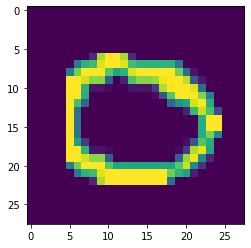

0


In [7]:
plt.imshow(X_val[660, :, :])
plt.show()

print(y_train[660])

### Convert to torch tensors

In [8]:
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)

X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val)

In [9]:
# (X_train_tensor - 128).float() / 128

In [10]:
X_train_tensor = X_train_tensor.float()
X_val_tensor = X_val_tensor.float()
# X_train_tensor = (X_train_tensor - 128).float() / 128
# X_val_tensor = (X_val_tensor - 128).float() / 128

# Add one dimension (necessary for convolution)
X_train_tensor = X_train_tensor.unsqueeze(1).float()
X_val_tensor = X_val_tensor.unsqueeze(1).float()

X_train_tensor.shape, X_val_tensor.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([10240, 1, 28, 28]))

### Define NN architecture

In [11]:
class MNISTNet3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #self.batch_norm0 = torch.nn.BatchNorm2d(1)
        # 28x28x1
        self.conv1_1 = torch.nn.Conv2d(1, 16, 3, padding=2)   # in_channels, out_channels, kernel_size
        # 30x30x16
        self.conv1_2 = torch.nn.Conv2d(16, 16, 3, padding=2)
        # 32x32x16
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(4)
        # 8x8x16
        self.conv2_1 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.conv2_2 = torch.nn.Conv2d(32, 32, 3, padding=1)
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2)
        # 4x4x32
        self.conv3_1 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.conv3_2 = torch.nn.Conv2d(64, 64, 3, padding=1)
        self.batch_norm3 = torch.nn.BatchNorm2d(64)
        self.pool3 = torch.nn.MaxPool2d(2)
        # 2x2x64
        self.conv4_1 = torch.nn.Conv2d(64, 128, 3, padding=1)
        self.conv4_2 = torch.nn.Conv2d(128, 128, 3, padding=1)
        self.batch_norm4 = torch.nn.BatchNorm2d(128)
        self.pool4 = torch.nn.MaxPool2d(2)
        # 1x1x128  = 128
        #self.drop1 = torch.nn.Dropout2d(p=0.5)

        #self.fc1 = torch.nn.Linear(128, 128)
        #self.batch_norm99 = torch.nn.BatchNorm1d(128)
        self.fc2 = torch.nn.Linear(128, 10)
        # self.ac3 = torch.nn.Softmax()   # Мы используем Cross-Entropy LOSS, а она принимает выходы и без Softmax

        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        #x = self.batch_norm0(x)
        x = self.conv1_1(x)
        x = self.relu(x)
        x = self.conv1_2(x)
        x = self.relu(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        # print(x.shape)

        x = self.conv2_1(x)
        x = self.relu(x)
        x = self.conv2_2(x)
        x = self.relu(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        # print(x.shape)

        x = self.conv3_1(x)
        x = self.relu(x)
        x = self.conv3_2(x)
        x = self.relu(x)
        x = self.batch_norm3(x)
        x = self.pool3(x)
        # print(x.shape)

        x = self.conv4_1(x)
        x = self.relu(x)
        x = self.conv4_2(x)
        x = self.relu(x)
        x = self.batch_norm4(x)
        x = self.pool4(x)

        
        #x = self.drop1(x)

        #print(x.size(1), x.size(2), x.size(3))
        x = x.view(x.size(0), 128)
        
        # print(x.shape)
        #x = self.fc1(x)
        #x = self.relu(x)
        #x = self.batch_norm99(x)
        # print(x.shape)
        
        x = self.fc2(x)
        #x = self.ac3(x)
                
        return x
    
CNN = MNISTNet3()
CNN = CNN.cuda()

### Define Loss and Optimizer

In [12]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN.parameters(), lr=0.00005, weight_decay=0.01)
#optimizer = torch.optim.RMSprop(CNN.parameters(), lr=0.0001) # , weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=37, gamma=0.25)
#optimizer = torch.optim.SGD(CNN.parameters(), lr=0.001, momentum=0.9)

### Run CNN!

In [13]:
batch_size = 250   # Кол-во объектов должно делиться на размер батча без остатка!

train_loss_history = []
val_loss_history = []
val_accuracy_history = []
max_accuracy = 0

X_val_tensor = X_val_tensor.cuda()
y_val_tensor = y_val_tensor.cuda()

for epoch in range(80):
    order = np.random.permutation(len(X_train_tensor))

    for start_index in range(0, len(X_train_tensor), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train_tensor[batch_indexes].cuda()
        y_batch = y_train_tensor[batch_indexes].cuda()
        
        preds = CNN.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()
    
    scheduler.step()
    
    # History part
    
    train_loss_history.append(loss_value.data.cpu())   # Save train Loss

    preds = CNN.forward(X_val_tensor)
    loss_val = loss(preds, y_val_tensor).data.cpu() # Validation Loss
    val_loss_history.append(loss_val)   
    
    accuracy = (preds.argmax(dim=1) == y_val_tensor).float().mean().data.cpu().numpy().item()
    val_accuracy_history.append(accuracy)

    #if accuracy > max_accuracy:
    print(f'epoch {epoch}, accuracy {accuracy * 100:.2f} %, loss {loss_val:.4f}')
    #max_accuracy = accuracy

    

epoch 0, accuracy 71.53 %, loss 0.9079
epoch 1, accuracy 75.33 %, loss 0.8123
epoch 2, accuracy 74.87 %, loss 0.8257
epoch 3, accuracy 76.12 %, loss 0.7881
epoch 4, accuracy 77.45 %, loss 0.7493
epoch 5, accuracy 77.15 %, loss 0.7685
epoch 6, accuracy 78.03 %, loss 0.7496
epoch 7, accuracy 77.01 %, loss 0.7794
epoch 8, accuracy 78.15 %, loss 0.7478
epoch 9, accuracy 78.64 %, loss 0.7479
epoch 10, accuracy 79.18 %, loss 0.7279
epoch 11, accuracy 78.77 %, loss 0.7447
epoch 12, accuracy 78.77 %, loss 0.7498
epoch 13, accuracy 79.31 %, loss 0.7412
epoch 14, accuracy 77.59 %, loss 0.7973
epoch 15, accuracy 79.24 %, loss 0.7438
epoch 16, accuracy 79.23 %, loss 0.7399
epoch 17, accuracy 79.21 %, loss 0.7542
epoch 18, accuracy 79.46 %, loss 0.7469
epoch 19, accuracy 78.68 %, loss 0.7768
epoch 20, accuracy 79.60 %, loss 0.7463
epoch 21, accuracy 79.29 %, loss 0.7541
epoch 22, accuracy 79.39 %, loss 0.7701
epoch 23, accuracy 80.28 %, loss 0.7379
epoch 24, accuracy 79.82 %, loss 0.7746
epoch 25, 

### Free GPU memory

In [14]:
X_batch = X_batch.cpu()
y_batch = y_batch.cpu()

preds = preds.cpu()

X_val_tensor = X_val_tensor.cpu()
y_val_tensor = y_val_tensor.cpu()

torch.cuda.empty_cache()

### Accuracy graph

0.8046777486801148


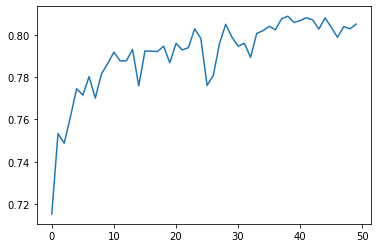

In [15]:
print(sum(val_accuracy_history[-10:]) / 10)
plt.plot(val_accuracy_history);

### Train Loss / Validation Loss graph

Wall time: 1.97 ms


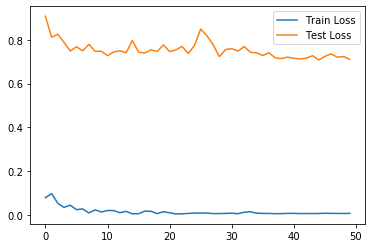

In [16]:
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Test Loss')
plt.legend();

### Convert X_test tensor

In [17]:
df_test.head(3)

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
X_test = df_test.drop(['id'], axis=1)
X_test.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df_test.iloc[:, :0]

""
0
1
2
3
4
...
4995
4996
4997
4998


In [20]:
X_test.shape

(5000, 784)

In [21]:
X_test_tensor = torch.tensor(X_test.values.reshape([-1, 28, 28]))
X_test_tensor = X_test_tensor.unsqueeze(1).float()
X_test_tensor.shape

torch.Size([5000, 1, 28, 28])

### Predict on test set

In [22]:
# CPU
# CNN = CNN.cpu()

# batch_size = 500  # Best For my 6Gb GPU

# y_preds = np.array([]).astype(int)

# X_test_tensor = X_test_tensor.cpu()

# for start_index in range(0, len(X_test_tensor), batch_size):
#     print(start_index, start_index+batch_size)
#     X_batch = X_test_tensor[start_index : start_index + batch_size]
#     y_pred = CNN.forward(X_batch)
#     y_pred = y_pred.argmax(dim=1).numpy()
    
#     y_preds = np.append(y_preds, y_pred)


In [23]:
# Прогоняеми по частям, чтобы на GPU
CNN = CNN.cuda()
batch_size = 50  # Best For my 6Gb GPU

y_preds = np.array([]).astype(int)

X_test_tensor = X_test_tensor.cuda()

for start_index in range(0, len(X_test_tensor), batch_size):
    print(start_index, start_index+batch_size)
    X_batch = X_test_tensor[start_index : start_index + batch_size].cuda()
    y_pred = CNN.forward(X_batch)
    y_pred = y_pred.argmax(dim=1).cpu().numpy()
    
    y_preds = np.append(y_preds, y_pred)


0 50
50 100
100 150
150 200
200 250
250 300
300 350
350 400
400 450
450 500
500 550
550 600
600 650
650 700
700 750
750 800
800 850
850 900
900 950
950 1000
1000 1050
1050 1100
1100 1150
1150 1200
1200 1250
1250 1300
1300 1350
1350 1400
1400 1450
1450 1500
1500 1550
1550 1600
1600 1650
1650 1700
1700 1750
1750 1800
1800 1850
1850 1900
1900 1950
1950 2000
2000 2050
2050 2100
2100 2150
2150 2200
2200 2250
2250 2300
2300 2350
2350 2400
2400 2450
2450 2500
2500 2550
2550 2600
2600 2650
2650 2700
2700 2750
2750 2800
2800 2850
2850 2900
2900 2950
2950 3000
3000 3050
3050 3100
3100 3150
3150 3200
3200 3250
3250 3300
3300 3350
3350 3400
3400 3450
3450 3500
3500 3550
3550 3600
3600 3650
3650 3700
3700 3750
3750 3800
3800 3850
3850 3900
3900 3950
3950 4000
4000 4050
4050 4100
4100 4150
4150 4200
4200 4250
4250 4300
4300 4350
4350 4400
4400 4450
4450 4500
4500 4550
4550 4600
4600 4650
4650 4700
4700 4750
4750 4800
4800 4850
4850 4900
4900 4950
4950 5000


In [24]:
y_preds

array([3, 0, 2, ..., 1, 6, 3], dtype=int64)

### Reindex output array and append results

In [25]:
y_output = df_test.iloc[:, :0]
#y_output.index = range(1, 28001)
y_output

""
0
1
2
3
4
...
4995
4996
4997
4998


In [26]:
y_output['label'] = y_preds
y_output.index.name = 'id'

C:\Users\sergs\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
y_output

,label
id,
0,3
1,0
2,2
3,6
4,7
...,...
4995,1
4996,1
4997,1


### Save results

In [28]:
y_output.to_csv('submission.csv')